## **Project Description**
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## **Columns Description**
**datetime** - hourly date + timestamp

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** 
  - 1: Clear, Few clouds, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

# **EDA**


In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
test_df = pd.read_csv("/content/test.csv")
train_df = pd.read_csv("/content/train.csv")

In [264]:
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [265]:
test_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [11]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
train_df.describe(include=np.object)      # if you wanna get statistics for object dtype

## **1. Null 값 확인 및 처리**
- 이 dataset 에는 모든 column 의 값이 다 non-null 이라 필요없긴 함

In [102]:
train_df_2.isnull().sum()   # null 값 확인
train_df_2 = train_df_2.dropna()

## **2. Outliers 처리**
- seanson, holiday, workingday, weather 은 categorical value 
- numeric data 만 선별해서 이상치 visualization

In [267]:
numeric_df = train_df.iloc[:, 5:-3]
numeric_df.head(5)

,temp,atemp,humidity,windspeed
0,9.84,14.395,81,0.0
1,9.02,13.635,80,0.0
2,9.02,13.635,80,0.0
3,9.84,14.395,75,0.0
4,9.84,14.395,75,0.0


In [270]:
cols = numeric_df.columns

### **Visualization with Box-Plot**
- median, Q1, Q3, IQR(Q3 - Q1)
- **outliers** : dots out of lower, upper fence which represents [Q1 - 1.5xIQR] or [Q3 + 1.5xIQR] for each



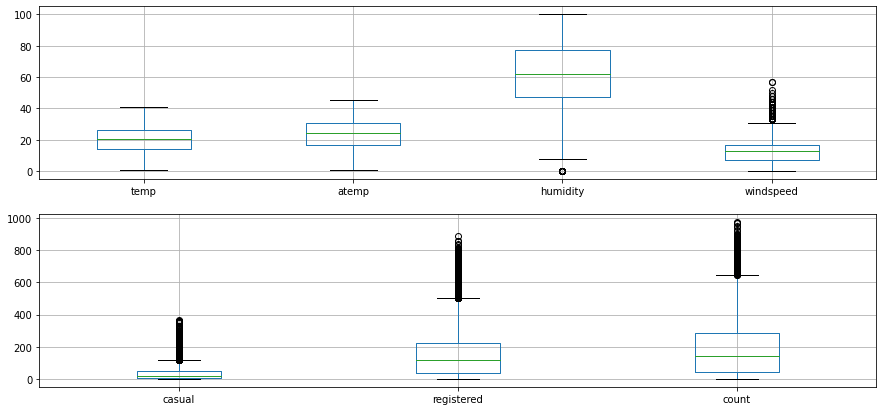

In [31]:
cols = numeric_df.columns

fig, axes = plt.subplots(2, 1, figsize=(15, 7))
ax = axes.flatten()
numeric_df[cols[:4]].boxplot(ax=ax[0])
numeric_df[cols[4:]].boxplot(ax=ax[1])
plt.show()

- windspeed : 
  - 풍속을 의미하는데, 평균이 12 언저리, Q3 가 대략 16 인데 max 값은 거의 60 가까이 된다. 실제로 boxplot 을 보면 outlier 들이 upper fence 위에 존해하는 것을 확인할 수 있다.
- casual, registered, count
  - 애초에 describe 를 보면 std 값이 mena 값보다 더 크게 형성되어 있다. boxplot 을 봐도 outlier 들이 굉장히 많이 존재하는 것을 확인할 수 있다.


### **Sigma-Clipping Operation**
-  Compute its median m and its standard deviation sigma . Keep only the data that falls in the range ( m-a*sigma , m+a*sigma ) for some value of a , and discard everything else.
- **df.query** : extract data only that matches with set condition 
  

In [271]:
for col in cols:
  quartiles = np.percentile(numeric_df[col], [25, 50, 75])
  q1, mu, q3 = [x for x in quartiles]
  IQR = q3 - q1
  str_exp1 = f'{col} > {mu}-1.5*{IQR}'
  str_exp2 = f'{col} < {mu}+1.5*{IQR}'
  train_df = train_df.query(str_exp1 and str_exp2)
  print("{0} - 평균 : {1} / Q1 : {2} / Q3 : {3}".format(col, mu, q1, q3))

temp - 평균 : 20.5 / Q1 : 13.94 / Q3 : 26.24
atemp - 평균 : 24.24 / Q1 : 16.665 / Q3 : 31.06
humidity - 평균 : 62.0 / Q1 : 47.0 / Q3 : 77.0
windspeed - 평균 : 12.998 / Q1 : 7.0015 / Q3 : 16.9979


In [272]:
# 이상치 제거 전 : 10886

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10265 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10265 non-null  object 
 1   season      10265 non-null  int64  
 2   holiday     10265 non-null  int64  
 3   workingday  10265 non-null  int64  
 4   weather     10265 non-null  int64  
 5   temp        10265 non-null  float64
 6   atemp       10265 non-null  float64
 7   humidity    10265 non-null  int64  
 8   windspeed   10265 non-null  float64
 9   casual      10265 non-null  int64  
 10  registered  10265 non-null  int64  
 11  count       10265 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.0+ MB


In [ ]:
# 이상치 제거 후  : 10123

train_df.info()

In [162]:
train_df_2 = train_df_2
train_df_2.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000
mean,2.489578,0.029438,0.678554,1.430702,19.825969,23.222557,62.694853,12.688538,30.121999,127.562383,157.684382
std,1.129251,0.169039,0.467055,0.641092,7.758019,8.456155,19.163366,8.174705,40.043560,108.905534,134.387158
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,3.000000,31.000000,36.000000
50%,2.000000,0.000000,1.000000,1.000000,19.680000,23.485000,63.000000,11.001400,14.000000,107.000000,129.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,30.305000,78.000000,16.997900,41.000000,196.000000,247.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,272.000000,498.000000,507.000000


In [ ]:
# numeric_df_2 = train_df_2.iloc[:, 5:]
# cols = numeric_df_2.columns

# fig, axes = plt.subplots(2, 1, figsize=(15, 7))
# ax = axes.flatten()
# numeric_df_2[cols[:4]].boxplot(ax=ax[0])
# numeric_df_2[cols[4:]].boxplot(ax=ax[1])
# plt.show()

## **3. Scaling : Standardization vs Normalization**
- **Standard Scaling** (using Z-score) : 표준화
   - rescales data to have a mean of 0 and a standard deviation of 1
   - 표준화 이후 z-score 의 절댓값이 2 를 넘어가는 data 를 지워주어 이상치 제거하는 데에도 사용될 수 있다.
   - SVM, 선형회귀, 로지스틱 회귀의 경우에는 데이터가 가우시안 분포(연속확률분포)를 가지고 있다고 가정하고 구현되었기 때문에 표준화 하는게 바람직 함
- **Min-Max Scaling** : 정규화
 - rescale the value ranging from 0 ~ 1
- **Robust Scaling**
  - StandardScaler와 비슷 하지만 평균과 분산대신 중간값(median)과 사분위값(quartile)을 사용 
  - 중앙값을 0, IQR 이 1 이 되도록 데이터를 변환함
  - 이상치의 영향을 최소한으로 줄여준다.

- [Scailing 방법론 별 비교](https://mkjjo.github.io/python/2019/01/10/scaler.html)
<br/>

**주의 !**
학습 데이터로 fit(), transform()을 적용하고 테스트 데이터에서 다시 fit()을 수행하지 않고 학습데이터로 fit() 적용한 결과를 이용해서 transform()을 적용해야 한다

### **3-1) Standard Score (Z-score) Scaling** 
- code 구현
- StandardScaler() 사용

 

In [142]:
std_scaled_1 = train_df_2

In [ ]:
# 직접
for col in cols:
    mean = std_scaled_1[col].mean()
    std = std_scaled_1[col].std()
    std_scaled_1[col] = std_scaled_1[col].apply(lambda x: (x-mean)/std)

In [114]:
std_scaled_1.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10123.000000,10123.000000,10123.000000,10123.000000,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04
mean,2.489578,0.029438,0.678554,1.430702,3.712584e-15,3.886493e-15,5.401082e-16,-3.649851e-14,6.459759e-17,-5.098603e-16,2.870041e-16
std,1.129251,0.169039,0.467055,0.641092,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,0.000000,0.000000,1.000000,-2.449848e+00,-2.656356e+00,-3.271599e+00,-1.552171e+00,-7.522308e-01,-1.171312e+00,-1.165918e+00
25%,1.000000,0.000000,0.000000,1.000000,-7.586948e-01,-7.754774e-01,-7.668201e-01,-6.956872e-01,-6.773124e-01,-8.866619e-01,-9.054763e-01
50%,2.000000,0.000000,1.000000,1.000000,-1.881519e-02,3.103579e-02,1.592344e-02,-2.063852e-01,-4.026115e-01,-1.888093e-01,-2.134459e-01
75%,4.000000,0.000000,1.000000,2.000000,8.267615e-01,8.375490e-01,7.986669e-01,5.271581e-01,2.716542e-01,6.284127e-01,6.646142e-01
max,4.000000,1.000000,1.000000,4.000000,2.729309e+00,2.629143e+00,1.946691e+00,5.420179e+00,6.040372e+00,3.401458e+00,2.599323e+00


In [184]:
# sklearn modue : StandardScaler()
from sklearn.preprocessing import StandardScaler

std_scaled_2 = train_df_2
scaler_std = StandardScaler()

std_scaled_2.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
for col in cols:
    new_name = f"{col}_scaled"
    scaler_std = scaler_std.fit(std_scaled_2[col].values.reshape(-1,1))
    std_scaled_2[new_name] = scaler_std.transform(std_scaled_2[col].values.reshape(-1,1))
    std_scaled_2.drop(col, axis=1, inplace=True)

In [186]:
std_scaled_2.describe()

# 결과는 직접한 것과 거의 유사하지만 mean 값이 서로 다르게 구해짐. 이유는...?

,season,holiday,workingday,weather,temp_scaled,atemp_scaled,humidity_scaled,windspeed_scaled,casual_scaled,registered_scaled,count_scaled
count,10123.000000,10123.000000,10123.000000,10123.000000,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04,1.012300e+04
mean,2.489578,0.029438,0.678554,1.430702,1.591360e-16,7.275289e-16,1.832806e-16,2.506737e-15,3.222860e-16,-1.384691e-15,-8.549584e-16
std,1.129251,0.169039,0.467055,0.641092,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,1.000000,0.000000,0.000000,1.000000,-2.449969e+00,-2.656487e+00,-3.271761e+00,-1.552247e+00,-7.522680e-01,-1.171370e+00,-1.165975e+00
25%,1.000000,0.000000,0.000000,1.000000,-7.587323e-01,-7.755157e-01,-7.668579e-01,-6.957216e-01,-6.773458e-01,-8.867057e-01,-9.055210e-01
50%,2.000000,0.000000,1.000000,1.000000,-1.881612e-02,3.103732e-02,1.592423e-02,-2.063954e-01,-4.026314e-01,-1.888187e-01,-2.134564e-01
75%,4.000000,0.000000,1.000000,2.000000,8.268024e-01,8.375903e-01,7.987064e-01,5.271842e-01,2.716676e-01,6.284437e-01,6.646471e-01
max,4.000000,1.000000,1.000000,4.000000,2.729444e+00,2.629273e+00,1.946787e+00,5.420447e+00,6.040670e+00,3.401626e+00,2.599451e+00


In [ ]:
std_scaled_2.info()

### **3-2) Min-Max Scaling**


In [188]:
# sklearn modue : StandardScaler()
from sklearn.preprocessing import MinMaxScaler

mm_scaled = train_df_2
scaler_mm = MinMaxScaler()

In [ ]:
for col in cols:
    scaler_mm.fit(mm_scaled[col].values.reshape(-1,1))      # fitting
    mm_scaled[col] = scaler_mm.transform(mm_scaled[col].values.reshape(-1,1))     # transform

In [190]:
mm_scaled.describe()

# 결과는 직접한 것과 거의 유사

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000
mean,2.489578,0.029438,0.678554,1.430702,0.473021,0.502574,0.626949,0.222618,0.110743,0.256149,0.309653
std,1.129251,0.169039,0.467055,0.641092,0.193082,0.189197,0.191634,0.143424,0.147219,0.218686,0.265587
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.326531,0.355856,0.480000,0.122840,0.011029,0.062249,0.069170
50%,2.000000,0.000000,1.000000,1.000000,0.469388,0.508446,0.630000,0.193018,0.051471,0.214859,0.252964
75%,4.000000,0.000000,1.000000,2.000000,0.632653,0.661036,0.780000,0.298225,0.150735,0.393574,0.486166
max,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### **3-3) Robust Scaling**


In [208]:
from sklearn.preprocessing import RobustScaler

scaler_rb = RobustScaler()
rb_scaled = train_df_2

In [ ]:
for col in cols:
    scaler_rb.fit(rb_scaled[col].values.reshape(-1,1))      # fitting
    rb_scaled[col] = scaler_rb.transform(rb_scaled[col].values.reshape(-1,1))     # transform

In [210]:
rb_scaled.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000,10123.000000
mean,2.489578,0.029438,0.678554,1.430702,0.011867,-0.019241,-0.010172,0.168775,0.424263,0.124621,0.135945
std,1.129251,0.169039,0.467055,0.641092,0.630733,0.619953,0.638779,0.817765,1.053778,0.660034,0.636906
min,1.000000,0.000000,0.000000,1.000000,-1.533333,-1.666056,-2.100000,-1.100536,-0.368421,-0.648485,-0.606635
25%,1.000000,0.000000,0.000000,1.000000,-0.466667,-0.500000,-0.500000,-0.400134,-0.289474,-0.460606,-0.440758
50%,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,0.533333,0.500000,0.500000,0.599866,0.710526,0.539394,0.559242
max,4.000000,1.000000,1.000000,4.000000,1.733333,1.610704,1.233333,4.601206,6.789474,2.369697,1.791469


### **Comparison of Each Scaler**

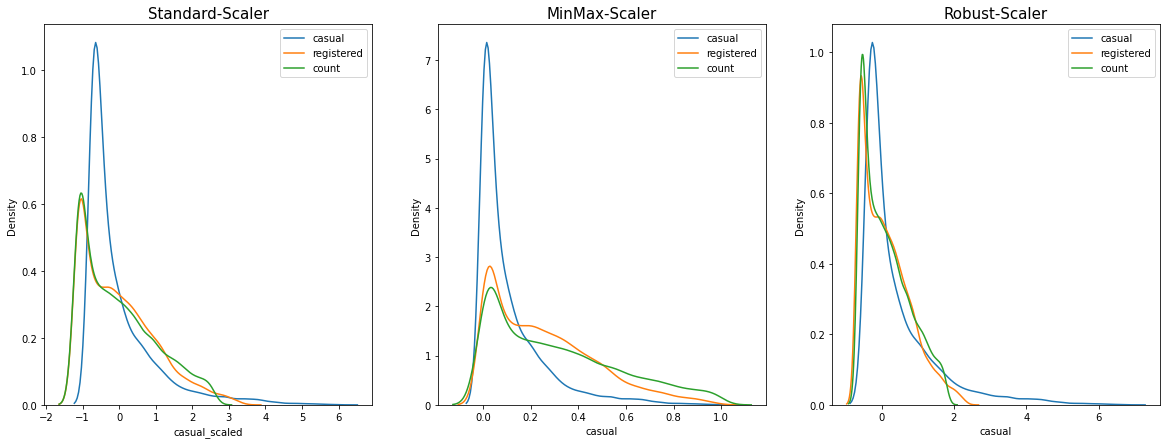

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
ax = axes.flatten()

sns.kdeplot(x=std_scaled_2['casual_scaled'], ax=ax[0], label='casual')
sns.kdeplot(x=std_scaled_2['registered_scaled'], ax=ax[0], label='registered')
sns.kdeplot(x=std_scaled_2['count_scaled'], ax=ax[0], label='count')
ax[0].legend()
ax[0].set_title("Standard-Scaler", fontsize=15)

sns.kdeplot(x=mm_scaled['casual'], ax=ax[1], label='casual')
sns.kdeplot(x=mm_scaled['registered'], ax=ax[1], label='registered')
sns.kdeplot(x=mm_scaled['count'], ax=ax[1], label='count')
ax[1].legend()
ax[1].set_title("MinMax-Scaler", fontsize=15)

sns.kdeplot(x=rb_scaled['casual'], ax=ax[2], label='casual')
sns.kdeplot(x=rb_scaled['registered'], ax=ax[2], label='registered')
sns.kdeplot(x=rb_scaled['count'], ax=ax[2], label='count')
ax[2].legend()
ax[2].set_title("Robust-Scaler", fontsize=15)

plt.show()

Robust-Scaler 적용한 traindata set rb_scaled 사용

In [ ]:
test_df

## **4. Encoding**
- Label Encoding
- One-Hot Encoding

In [ ]:
rb_scaled.head(10)

In [211]:
train = pd.DataFrame(rb_scaled)

# **Feature Selection**

In [236]:
test_df = pd.read_csv("/content/test.csv")
train_df = pd.read_csv("/content/train.csv")

In [273]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


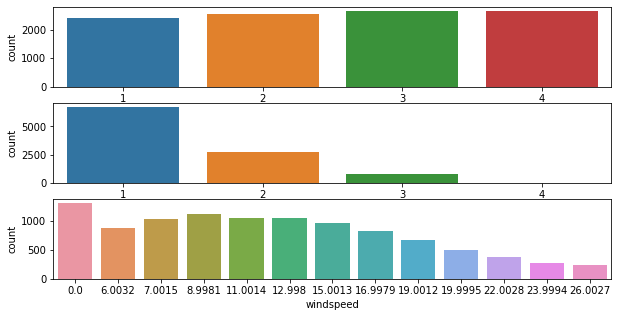

In [274]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(3,1, figsize = (10,5))

sns.countplot(train_df["season"], ax = axes[0])
sns.countplot(train_df["weather"], ax = axes[1])
sns.countplot(train_df["windspeed"], ax = axes[2])

In [275]:
x_df = train_df.iloc[:, :-3]
y_df = train_df.iloc[:, -1:]

In [276]:
x_df
y_df

,count
0,16
1,40
2,32
3,13
4,1
...,...
10881,336
10882,241
10883,168
10884,129


In [277]:
dt = pd.DatetimeIndex(x_df['datetime'])

In [278]:
x_df['date'] = dt.date
x_df['month'] = dt.month
x_df['year'] = dt.year
x_df['hour'] = dt.hour
x_df['dow'] = dt.dayofweek

In [ ]:
x_df.drop('datetime', axis=1, inplace=True)

In [281]:
x_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,month,year,hour,dow
0,1,0,0,1,9.84,14.395,81,0.0000,2011-01-01,1,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,2011-01-01,1,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,2011-01-01,1,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,2011-01-01,1,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,2011-01-01,1,2011,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2012-12-19,12,2012,19,2
10882,4,0,1,1,14.76,17.425,57,15.0013,2012-12-19,12,2012,20,2
10883,4,0,1,1,13.94,15.910,61,15.0013,2012-12-19,12,2012,21,2
10884,4,0,1,1,13.94,17.425,61,6.0032,2012-12-19,12,2012,22,2


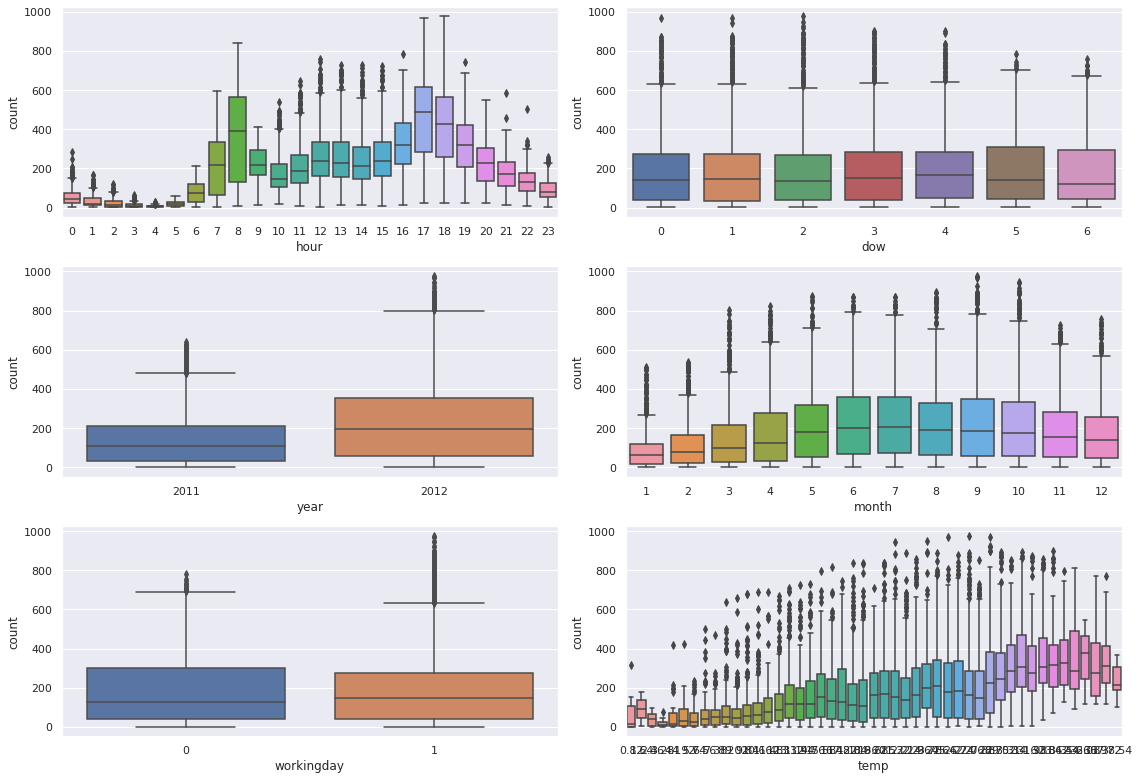

In [326]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(3, 2, figsize=(16, 11))
sns.boxplot(x=x_df["hour"], y=y_df["count"], ax=axes[0][0])
sns.boxplot(x=x_df["dow"], y=y_df["count"], ax=axes[0][1])
sns.boxplot(x=x_df["year"], y=y_df["count"], ax=axes[1][0])
sns.boxplot(x=x_df["month"], y=y_df["count"], ax=axes[1][1])
sns.boxplot(x=x_df["workingday"], y=y_df["count"], ax=axes[2][0])
sns.boxplot(x=x_df["temp"], y=y_df["count"], ax=axes[2][1])
plt.tight_layout()

In [ ]:
train_df

train_df['date'] = dt.date
train_df['month'] = dt.month
train_df['year'] = dt.year
train_df['hour'] = dt.hour
train_df['dow'] = dt.dayofweek

train_df

<Figure size 1296x936 with 0 Axes>

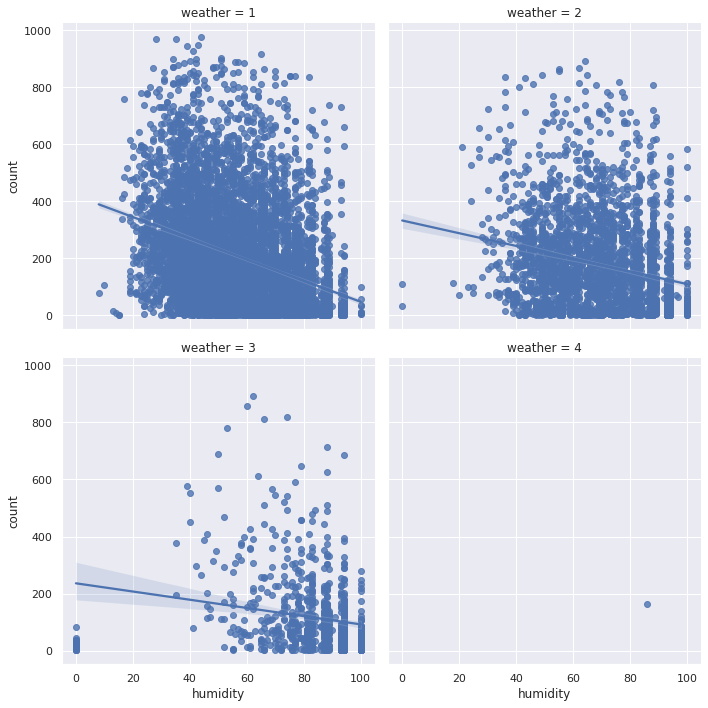

In [311]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 13))
sns.lmplot(x="humidity", y="count", data=train_df, col="weather", col_wrap=2)   # col_wrap : 한 줄에 표시할 column 개수

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 13))
sns.relplot(x="hour", y="count", data=train_df)

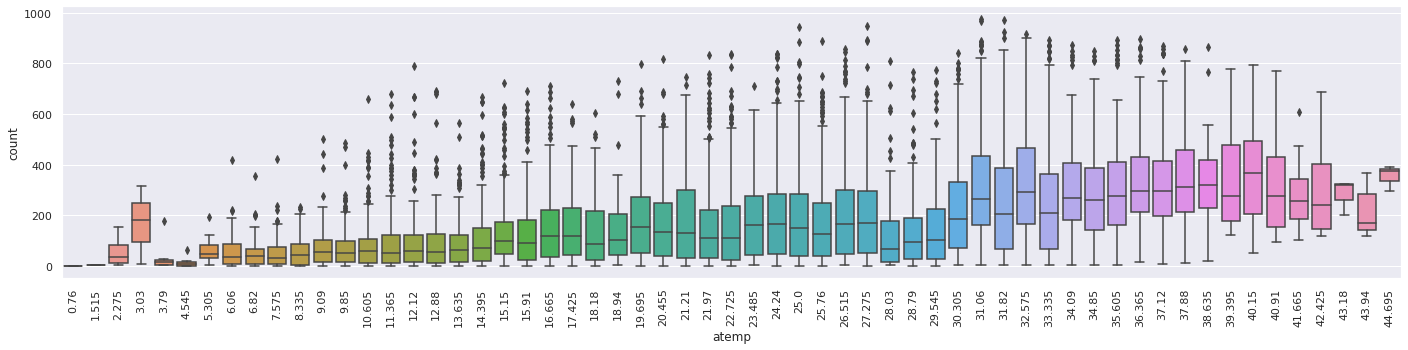

In [339]:
plt.figure(figsize=(24, 5))
g = sns.boxplot(x=x_df["atemp"], y=y_df["count"])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

## **중요 feature**
- date : month, hour
- weather : weather, humidity, temp, atemp